# WeightWatcher Analysis of the AdamW optimizer

This notebook examines the tendency of the AdamW optimizer to cause layers to overfit

We train a 3-layer MLP (MLP3) on MNIST using AdamW in an attempt to obtain the best test accuracy possible (98.5%)

We then examine the layer alphas, finding that the alphas for FC1 & FC2 are less than ideal 2.0





## Install weightwatcher if you need it

In [1]:
#!pip install weightwatcher

### Imports 

add more installs as necessary for your env

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import weightwatcher as ww
import logging
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import copy
import numpy as np


PyTorch is available but CUDA is not. Defaulting to NumPy for SVD
Import error , reetting to svd accurate methods


Running on macOS.
Running on macOS.


## Set your GPU or CPU

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


### Logging

In [4]:
# Setup logging
logging.basicConfig(filename="WW-MLP3-AdamW.log", level=logging.INFO, format="%(message)s")

### Define the MLP3

In [5]:
class MLP3(nn.Module):
    def __init__(self, input_size=784, hidden_size=512, output_size=10):
        super(MLP3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.nn.GELU()(self.fc1(x))#torch.nn.GELU()(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.nn.GELU()(self.fc2(x))#torch.nn.GELU()(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

### Define the Dataset (MNIST)

Use agumentation to improve test accuracy

In [6]:

# ================ Data Augmentation and MNIST Datasets ================
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Define the optimizer 

Here, we study AdamW with a cycled learning rate schedule

Note: large learning rates can also induce layer overfitting

In [17]:
# ================ Model, Loss, Optimizer, Scheduler ================

num_epochs = 100

model = MLP3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(train_loader))


experiment = "WW-MLP3-AdamW"

## Train Model

In [18]:
# ================ Helper Functions ================
def evaluate(model, data_loader, criterion, device):
    """
    Evaluate the model on a given loader; returns the average loss and accuracy (%).
    """
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            # Flatten from [batch, channels, H, W] -> [batch, 28*28]
            images = images.view(images.shape[0], -1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = (correct / total) * 100.0
    return avg_loss, accuracy
    

def run_weightwatcher(model, epoch, results_df, model_tag="no_drop"):
    """
    Run WeightWatcher on the current model. Append results to a DataFrame.
    """
    watcher = ww.WeightWatcher()
    details = watcher.analyze(model=model, plot=False)
    details["epoch"] = epoch
    details["model_tag"] = model_tag  # label it if needed
    return pd.concat([results_df, details], ignore_index=True)

# ================ Training Setup ================
best_test_acc = 0

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Single WeightWatcher DataFrame
ww_results = pd.DataFrame()

# ================ Main Training Loop ================
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Training metrics
    train_loss = total_loss / len(train_loader)
    train_acc = (correct / total) * 100.0
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    scheduler.step()

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(model.state_dict(), f"checkpoints/mlp3_best.pth")

    # ========== Run WeightWatcher once (no dropout modifications) ==========
    ww_results = run_weightwatcher(model, epoch, ww_results, model_tag="original")

    # Logging
    log_msg = (f"Epoch {epoch+1}/{num_epochs} - "
               f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
               f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(log_msg)
    logging.info(log_msg)

# ================ Save Results ================
ww_results.to_csv(f"ww_{experiment}_results.csv", index=False)

pd.DataFrame({
    "train_loss": train_losses,
    "test_loss": test_losses,
    "train_acc": train_accuracies,
    "test_acc": test_accuracies
}).to_csv(f"{experiment}_results.csv", index=False)

2025-03-19 15:41:50,207 - INFO - Epoch 1/100 - Train Loss: 0.7651, Train Acc: 75.11% | Test Loss: 0.3449, Test Acc: 89.56%


Epoch 1/100 - Train Loss: 0.7651, Train Acc: 75.11% | Test Loss: 0.3449, Test Acc: 89.56%


2025-03-19 15:41:59,026 - INFO - Epoch 2/100 - Train Loss: 0.3468, Train Acc: 89.30% | Test Loss: 0.2045, Test Acc: 93.86%


Epoch 2/100 - Train Loss: 0.3468, Train Acc: 89.30% | Test Loss: 0.2045, Test Acc: 93.86%


2025-03-19 15:42:07,666 - INFO - Epoch 3/100 - Train Loss: 0.2754, Train Acc: 91.55% | Test Loss: 0.1843, Test Acc: 94.20%


Epoch 3/100 - Train Loss: 0.2754, Train Acc: 91.55% | Test Loss: 0.1843, Test Acc: 94.20%


2025-03-19 15:42:16,365 - INFO - Epoch 4/100 - Train Loss: 0.2361, Train Acc: 92.57% | Test Loss: 0.1435, Test Acc: 95.40%


Epoch 4/100 - Train Loss: 0.2361, Train Acc: 92.57% | Test Loss: 0.1435, Test Acc: 95.40%


2025-03-19 15:42:24,375 - INFO - Epoch 5/100 - Train Loss: 0.2135, Train Acc: 93.25% | Test Loss: 0.1433, Test Acc: 95.29%


Epoch 5/100 - Train Loss: 0.2135, Train Acc: 93.25% | Test Loss: 0.1433, Test Acc: 95.29%


2025-03-19 15:42:32,476 - INFO - Epoch 6/100 - Train Loss: 0.2015, Train Acc: 93.62% | Test Loss: 0.1403, Test Acc: 95.59%


Epoch 6/100 - Train Loss: 0.2015, Train Acc: 93.62% | Test Loss: 0.1403, Test Acc: 95.59%


2025-03-19 15:42:40,572 - INFO - Epoch 7/100 - Train Loss: 0.1900, Train Acc: 94.12% | Test Loss: 0.1173, Test Acc: 96.12%


Epoch 7/100 - Train Loss: 0.1900, Train Acc: 94.12% | Test Loss: 0.1173, Test Acc: 96.12%


2025-03-19 15:42:49,487 - INFO - Epoch 8/100 - Train Loss: 0.1831, Train Acc: 94.33% | Test Loss: 0.1099, Test Acc: 96.58%


Epoch 8/100 - Train Loss: 0.1831, Train Acc: 94.33% | Test Loss: 0.1099, Test Acc: 96.58%


2025-03-19 15:42:59,008 - INFO - Epoch 9/100 - Train Loss: 0.1765, Train Acc: 94.47% | Test Loss: 0.1015, Test Acc: 96.92%


Epoch 9/100 - Train Loss: 0.1765, Train Acc: 94.47% | Test Loss: 0.1015, Test Acc: 96.92%


2025-03-19 15:43:07,472 - INFO - Epoch 10/100 - Train Loss: 0.1708, Train Acc: 94.73% | Test Loss: 0.0943, Test Acc: 96.89%


Epoch 10/100 - Train Loss: 0.1708, Train Acc: 94.73% | Test Loss: 0.0943, Test Acc: 96.89%


2025-03-19 15:43:16,612 - INFO - Epoch 11/100 - Train Loss: 0.1624, Train Acc: 95.00% | Test Loss: 0.1116, Test Acc: 96.65%


Epoch 11/100 - Train Loss: 0.1624, Train Acc: 95.00% | Test Loss: 0.1116, Test Acc: 96.65%


2025-03-19 15:43:26,051 - INFO - Epoch 12/100 - Train Loss: 0.1653, Train Acc: 94.96% | Test Loss: 0.1026, Test Acc: 96.60%


Epoch 12/100 - Train Loss: 0.1653, Train Acc: 94.96% | Test Loss: 0.1026, Test Acc: 96.60%


2025-03-19 15:43:34,982 - INFO - Epoch 13/100 - Train Loss: 0.1576, Train Acc: 95.12% | Test Loss: 0.0884, Test Acc: 97.24%


Epoch 13/100 - Train Loss: 0.1576, Train Acc: 95.12% | Test Loss: 0.0884, Test Acc: 97.24%


2025-03-19 15:43:43,426 - INFO - Epoch 14/100 - Train Loss: 0.1545, Train Acc: 95.21% | Test Loss: 0.0864, Test Acc: 97.12%


Epoch 14/100 - Train Loss: 0.1545, Train Acc: 95.21% | Test Loss: 0.0864, Test Acc: 97.12%


2025-03-19 15:43:52,344 - INFO - Epoch 15/100 - Train Loss: 0.1513, Train Acc: 95.30% | Test Loss: 0.0848, Test Acc: 97.09%


Epoch 15/100 - Train Loss: 0.1513, Train Acc: 95.30% | Test Loss: 0.0848, Test Acc: 97.09%


2025-03-19 15:44:01,412 - INFO - Epoch 16/100 - Train Loss: 0.1501, Train Acc: 95.38% | Test Loss: 0.0831, Test Acc: 97.42%


Epoch 16/100 - Train Loss: 0.1501, Train Acc: 95.38% | Test Loss: 0.0831, Test Acc: 97.42%


2025-03-19 15:44:10,266 - INFO - Epoch 17/100 - Train Loss: 0.1491, Train Acc: 95.38% | Test Loss: 0.0843, Test Acc: 97.15%


Epoch 17/100 - Train Loss: 0.1491, Train Acc: 95.38% | Test Loss: 0.0843, Test Acc: 97.15%


2025-03-19 15:44:18,962 - INFO - Epoch 18/100 - Train Loss: 0.1470, Train Acc: 95.52% | Test Loss: 0.0780, Test Acc: 97.55%


Epoch 18/100 - Train Loss: 0.1470, Train Acc: 95.52% | Test Loss: 0.0780, Test Acc: 97.55%


2025-03-19 15:44:27,218 - INFO - Epoch 19/100 - Train Loss: 0.1477, Train Acc: 95.49% | Test Loss: 0.0793, Test Acc: 97.27%


Epoch 19/100 - Train Loss: 0.1477, Train Acc: 95.49% | Test Loss: 0.0793, Test Acc: 97.27%


2025-03-19 15:44:35,487 - INFO - Epoch 20/100 - Train Loss: 0.1434, Train Acc: 95.62% | Test Loss: 0.0805, Test Acc: 97.47%


Epoch 20/100 - Train Loss: 0.1434, Train Acc: 95.62% | Test Loss: 0.0805, Test Acc: 97.47%


2025-03-19 15:44:43,704 - INFO - Epoch 21/100 - Train Loss: 0.1379, Train Acc: 95.64% | Test Loss: 0.0859, Test Acc: 97.33%


Epoch 21/100 - Train Loss: 0.1379, Train Acc: 95.64% | Test Loss: 0.0859, Test Acc: 97.33%


2025-03-19 15:44:52,004 - INFO - Epoch 22/100 - Train Loss: 0.1405, Train Acc: 95.65% | Test Loss: 0.0760, Test Acc: 97.64%


Epoch 22/100 - Train Loss: 0.1405, Train Acc: 95.65% | Test Loss: 0.0760, Test Acc: 97.64%


2025-03-19 15:45:00,245 - INFO - Epoch 23/100 - Train Loss: 0.1374, Train Acc: 95.75% | Test Loss: 0.0800, Test Acc: 97.37%


Epoch 23/100 - Train Loss: 0.1374, Train Acc: 95.75% | Test Loss: 0.0800, Test Acc: 97.37%


2025-03-19 15:45:08,379 - INFO - Epoch 24/100 - Train Loss: 0.1380, Train Acc: 95.84% | Test Loss: 0.0863, Test Acc: 97.15%


Epoch 24/100 - Train Loss: 0.1380, Train Acc: 95.84% | Test Loss: 0.0863, Test Acc: 97.15%


2025-03-19 15:45:16,600 - INFO - Epoch 25/100 - Train Loss: 0.1388, Train Acc: 95.73% | Test Loss: 0.0795, Test Acc: 97.47%


Epoch 25/100 - Train Loss: 0.1388, Train Acc: 95.73% | Test Loss: 0.0795, Test Acc: 97.47%


2025-03-19 15:45:24,789 - INFO - Epoch 26/100 - Train Loss: 0.1341, Train Acc: 95.85% | Test Loss: 0.0740, Test Acc: 97.55%


Epoch 26/100 - Train Loss: 0.1341, Train Acc: 95.85% | Test Loss: 0.0740, Test Acc: 97.55%


2025-03-19 15:45:32,913 - INFO - Epoch 27/100 - Train Loss: 0.1357, Train Acc: 95.83% | Test Loss: 0.0820, Test Acc: 97.54%


Epoch 27/100 - Train Loss: 0.1357, Train Acc: 95.83% | Test Loss: 0.0820, Test Acc: 97.54%


2025-03-19 15:45:41,066 - INFO - Epoch 28/100 - Train Loss: 0.1354, Train Acc: 95.84% | Test Loss: 0.0677, Test Acc: 97.86%


Epoch 28/100 - Train Loss: 0.1354, Train Acc: 95.84% | Test Loss: 0.0677, Test Acc: 97.86%


2025-03-19 15:45:49,240 - INFO - Epoch 29/100 - Train Loss: 0.1296, Train Acc: 95.95% | Test Loss: 0.0666, Test Acc: 97.83%


Epoch 29/100 - Train Loss: 0.1296, Train Acc: 95.95% | Test Loss: 0.0666, Test Acc: 97.83%


2025-03-19 15:45:57,556 - INFO - Epoch 30/100 - Train Loss: 0.1318, Train Acc: 95.94% | Test Loss: 0.0776, Test Acc: 97.49%


Epoch 30/100 - Train Loss: 0.1318, Train Acc: 95.94% | Test Loss: 0.0776, Test Acc: 97.49%


2025-03-19 15:46:05,691 - INFO - Epoch 31/100 - Train Loss: 0.1310, Train Acc: 96.08% | Test Loss: 0.0716, Test Acc: 97.73%


Epoch 31/100 - Train Loss: 0.1310, Train Acc: 96.08% | Test Loss: 0.0716, Test Acc: 97.73%


2025-03-19 15:46:15,264 - INFO - Epoch 32/100 - Train Loss: 0.1260, Train Acc: 96.14% | Test Loss: 0.0680, Test Acc: 97.81%


Epoch 32/100 - Train Loss: 0.1260, Train Acc: 96.14% | Test Loss: 0.0680, Test Acc: 97.81%


2025-03-19 15:46:24,621 - INFO - Epoch 33/100 - Train Loss: 0.1283, Train Acc: 96.10% | Test Loss: 0.0697, Test Acc: 97.67%


Epoch 33/100 - Train Loss: 0.1283, Train Acc: 96.10% | Test Loss: 0.0697, Test Acc: 97.67%


2025-03-19 15:46:33,492 - INFO - Epoch 34/100 - Train Loss: 0.1258, Train Acc: 96.21% | Test Loss: 0.0688, Test Acc: 97.83%


Epoch 34/100 - Train Loss: 0.1258, Train Acc: 96.21% | Test Loss: 0.0688, Test Acc: 97.83%


2025-03-19 15:46:42,148 - INFO - Epoch 35/100 - Train Loss: 0.1274, Train Acc: 96.06% | Test Loss: 0.0683, Test Acc: 97.87%


Epoch 35/100 - Train Loss: 0.1274, Train Acc: 96.06% | Test Loss: 0.0683, Test Acc: 97.87%


2025-03-19 15:46:50,652 - INFO - Epoch 36/100 - Train Loss: 0.1328, Train Acc: 96.03% | Test Loss: 0.0654, Test Acc: 97.86%


Epoch 36/100 - Train Loss: 0.1328, Train Acc: 96.03% | Test Loss: 0.0654, Test Acc: 97.86%


2025-03-19 15:46:59,757 - INFO - Epoch 37/100 - Train Loss: 0.1257, Train Acc: 96.19% | Test Loss: 0.0721, Test Acc: 97.70%


Epoch 37/100 - Train Loss: 0.1257, Train Acc: 96.19% | Test Loss: 0.0721, Test Acc: 97.70%


2025-03-19 15:47:08,314 - INFO - Epoch 38/100 - Train Loss: 0.1224, Train Acc: 96.32% | Test Loss: 0.0655, Test Acc: 97.85%


Epoch 38/100 - Train Loss: 0.1224, Train Acc: 96.32% | Test Loss: 0.0655, Test Acc: 97.85%


2025-03-19 15:47:17,558 - INFO - Epoch 39/100 - Train Loss: 0.1241, Train Acc: 96.28% | Test Loss: 0.0651, Test Acc: 98.11%


Epoch 39/100 - Train Loss: 0.1241, Train Acc: 96.28% | Test Loss: 0.0651, Test Acc: 98.11%


2025-03-19 15:47:26,780 - INFO - Epoch 40/100 - Train Loss: 0.1222, Train Acc: 96.20% | Test Loss: 0.0633, Test Acc: 98.06%


Epoch 40/100 - Train Loss: 0.1222, Train Acc: 96.20% | Test Loss: 0.0633, Test Acc: 98.06%


2025-03-19 15:47:35,457 - INFO - Epoch 41/100 - Train Loss: 0.1239, Train Acc: 96.20% | Test Loss: 0.0592, Test Acc: 98.08%


Epoch 41/100 - Train Loss: 0.1239, Train Acc: 96.20% | Test Loss: 0.0592, Test Acc: 98.08%


2025-03-19 15:47:43,711 - INFO - Epoch 42/100 - Train Loss: 0.1237, Train Acc: 96.29% | Test Loss: 0.0641, Test Acc: 97.90%


Epoch 42/100 - Train Loss: 0.1237, Train Acc: 96.29% | Test Loss: 0.0641, Test Acc: 97.90%


2025-03-19 15:47:51,932 - INFO - Epoch 43/100 - Train Loss: 0.1216, Train Acc: 96.40% | Test Loss: 0.0636, Test Acc: 97.97%


Epoch 43/100 - Train Loss: 0.1216, Train Acc: 96.40% | Test Loss: 0.0636, Test Acc: 97.97%


2025-03-19 15:48:00,211 - INFO - Epoch 44/100 - Train Loss: 0.1225, Train Acc: 96.20% | Test Loss: 0.0580, Test Acc: 98.04%


Epoch 44/100 - Train Loss: 0.1225, Train Acc: 96.20% | Test Loss: 0.0580, Test Acc: 98.04%


2025-03-19 15:48:09,207 - INFO - Epoch 45/100 - Train Loss: 0.1242, Train Acc: 96.35% | Test Loss: 0.0587, Test Acc: 98.08%


Epoch 45/100 - Train Loss: 0.1242, Train Acc: 96.35% | Test Loss: 0.0587, Test Acc: 98.08%


2025-03-19 15:48:18,866 - INFO - Epoch 46/100 - Train Loss: 0.1215, Train Acc: 96.31% | Test Loss: 0.0604, Test Acc: 97.95%


Epoch 46/100 - Train Loss: 0.1215, Train Acc: 96.31% | Test Loss: 0.0604, Test Acc: 97.95%


2025-03-19 15:48:28,187 - INFO - Epoch 47/100 - Train Loss: 0.1175, Train Acc: 96.50% | Test Loss: 0.0615, Test Acc: 98.06%


Epoch 47/100 - Train Loss: 0.1175, Train Acc: 96.50% | Test Loss: 0.0615, Test Acc: 98.06%


2025-03-19 15:48:37,671 - INFO - Epoch 48/100 - Train Loss: 0.1157, Train Acc: 96.52% | Test Loss: 0.0639, Test Acc: 97.90%


Epoch 48/100 - Train Loss: 0.1157, Train Acc: 96.52% | Test Loss: 0.0639, Test Acc: 97.90%


2025-03-19 15:48:46,600 - INFO - Epoch 49/100 - Train Loss: 0.1161, Train Acc: 96.51% | Test Loss: 0.0640, Test Acc: 97.93%


Epoch 49/100 - Train Loss: 0.1161, Train Acc: 96.51% | Test Loss: 0.0640, Test Acc: 97.93%


2025-03-19 15:48:55,525 - INFO - Epoch 50/100 - Train Loss: 0.1148, Train Acc: 96.56% | Test Loss: 0.0584, Test Acc: 98.16%


Epoch 50/100 - Train Loss: 0.1148, Train Acc: 96.56% | Test Loss: 0.0584, Test Acc: 98.16%


2025-03-19 15:49:04,843 - INFO - Epoch 51/100 - Train Loss: 0.1136, Train Acc: 96.55% | Test Loss: 0.0575, Test Acc: 98.14%


Epoch 51/100 - Train Loss: 0.1136, Train Acc: 96.55% | Test Loss: 0.0575, Test Acc: 98.14%


2025-03-19 15:49:14,338 - INFO - Epoch 52/100 - Train Loss: 0.1165, Train Acc: 96.41% | Test Loss: 0.0634, Test Acc: 97.84%


Epoch 52/100 - Train Loss: 0.1165, Train Acc: 96.41% | Test Loss: 0.0634, Test Acc: 97.84%


2025-03-19 15:49:22,909 - INFO - Epoch 53/100 - Train Loss: 0.1130, Train Acc: 96.54% | Test Loss: 0.0595, Test Acc: 98.12%


Epoch 53/100 - Train Loss: 0.1130, Train Acc: 96.54% | Test Loss: 0.0595, Test Acc: 98.12%


2025-03-19 15:49:31,226 - INFO - Epoch 54/100 - Train Loss: 0.1128, Train Acc: 96.63% | Test Loss: 0.0541, Test Acc: 98.20%


Epoch 54/100 - Train Loss: 0.1128, Train Acc: 96.63% | Test Loss: 0.0541, Test Acc: 98.20%


2025-03-19 15:49:39,921 - INFO - Epoch 55/100 - Train Loss: 0.1153, Train Acc: 96.47% | Test Loss: 0.0616, Test Acc: 98.05%


Epoch 55/100 - Train Loss: 0.1153, Train Acc: 96.47% | Test Loss: 0.0616, Test Acc: 98.05%


2025-03-19 15:49:48,218 - INFO - Epoch 56/100 - Train Loss: 0.1121, Train Acc: 96.57% | Test Loss: 0.0590, Test Acc: 98.07%


Epoch 56/100 - Train Loss: 0.1121, Train Acc: 96.57% | Test Loss: 0.0590, Test Acc: 98.07%


2025-03-19 15:49:57,004 - INFO - Epoch 57/100 - Train Loss: 0.1117, Train Acc: 96.67% | Test Loss: 0.0589, Test Acc: 98.15%


Epoch 57/100 - Train Loss: 0.1117, Train Acc: 96.67% | Test Loss: 0.0589, Test Acc: 98.15%


2025-03-19 15:50:05,374 - INFO - Epoch 58/100 - Train Loss: 0.1109, Train Acc: 96.58% | Test Loss: 0.0563, Test Acc: 98.13%


Epoch 58/100 - Train Loss: 0.1109, Train Acc: 96.58% | Test Loss: 0.0563, Test Acc: 98.13%


2025-03-19 15:50:13,811 - INFO - Epoch 59/100 - Train Loss: 0.1136, Train Acc: 96.59% | Test Loss: 0.0627, Test Acc: 97.98%


Epoch 59/100 - Train Loss: 0.1136, Train Acc: 96.59% | Test Loss: 0.0627, Test Acc: 97.98%


2025-03-19 15:50:23,432 - INFO - Epoch 60/100 - Train Loss: 0.1138, Train Acc: 96.64% | Test Loss: 0.0572, Test Acc: 98.15%


Epoch 60/100 - Train Loss: 0.1138, Train Acc: 96.64% | Test Loss: 0.0572, Test Acc: 98.15%


2025-03-19 15:50:32,112 - INFO - Epoch 61/100 - Train Loss: 0.1102, Train Acc: 96.69% | Test Loss: 0.0566, Test Acc: 98.27%


Epoch 61/100 - Train Loss: 0.1102, Train Acc: 96.69% | Test Loss: 0.0566, Test Acc: 98.27%


2025-03-19 15:50:41,954 - INFO - Epoch 62/100 - Train Loss: 0.1125, Train Acc: 96.62% | Test Loss: 0.0589, Test Acc: 98.04%


Epoch 62/100 - Train Loss: 0.1125, Train Acc: 96.62% | Test Loss: 0.0589, Test Acc: 98.04%


2025-03-19 15:50:50,856 - INFO - Epoch 63/100 - Train Loss: 0.1094, Train Acc: 96.64% | Test Loss: 0.0612, Test Acc: 98.02%


Epoch 63/100 - Train Loss: 0.1094, Train Acc: 96.64% | Test Loss: 0.0612, Test Acc: 98.02%


2025-03-19 15:50:59,000 - INFO - Epoch 64/100 - Train Loss: 0.1094, Train Acc: 96.71% | Test Loss: 0.0579, Test Acc: 98.07%


Epoch 64/100 - Train Loss: 0.1094, Train Acc: 96.71% | Test Loss: 0.0579, Test Acc: 98.07%


2025-03-19 15:51:07,294 - INFO - Epoch 65/100 - Train Loss: 0.1071, Train Acc: 96.77% | Test Loss: 0.0533, Test Acc: 98.24%


Epoch 65/100 - Train Loss: 0.1071, Train Acc: 96.77% | Test Loss: 0.0533, Test Acc: 98.24%


2025-03-19 15:51:16,109 - INFO - Epoch 66/100 - Train Loss: 0.1108, Train Acc: 96.72% | Test Loss: 0.0554, Test Acc: 98.33%


Epoch 66/100 - Train Loss: 0.1108, Train Acc: 96.72% | Test Loss: 0.0554, Test Acc: 98.33%


2025-03-19 15:51:24,518 - INFO - Epoch 67/100 - Train Loss: 0.1093, Train Acc: 96.69% | Test Loss: 0.0528, Test Acc: 98.49%


Epoch 67/100 - Train Loss: 0.1093, Train Acc: 96.69% | Test Loss: 0.0528, Test Acc: 98.49%


2025-03-19 15:51:34,626 - INFO - Epoch 68/100 - Train Loss: 0.1085, Train Acc: 96.77% | Test Loss: 0.0553, Test Acc: 98.19%


Epoch 68/100 - Train Loss: 0.1085, Train Acc: 96.77% | Test Loss: 0.0553, Test Acc: 98.19%


2025-03-19 15:51:43,451 - INFO - Epoch 69/100 - Train Loss: 0.1108, Train Acc: 96.68% | Test Loss: 0.0597, Test Acc: 98.07%


Epoch 69/100 - Train Loss: 0.1108, Train Acc: 96.68% | Test Loss: 0.0597, Test Acc: 98.07%


2025-03-19 15:51:52,146 - INFO - Epoch 70/100 - Train Loss: 0.1082, Train Acc: 96.69% | Test Loss: 0.0580, Test Acc: 98.09%


Epoch 70/100 - Train Loss: 0.1082, Train Acc: 96.69% | Test Loss: 0.0580, Test Acc: 98.09%


2025-03-19 15:52:00,559 - INFO - Epoch 71/100 - Train Loss: 0.1091, Train Acc: 96.76% | Test Loss: 0.0647, Test Acc: 97.86%


Epoch 71/100 - Train Loss: 0.1091, Train Acc: 96.76% | Test Loss: 0.0647, Test Acc: 97.86%


2025-03-19 15:52:09,567 - INFO - Epoch 72/100 - Train Loss: 0.1109, Train Acc: 96.69% | Test Loss: 0.0545, Test Acc: 98.20%


Epoch 72/100 - Train Loss: 0.1109, Train Acc: 96.69% | Test Loss: 0.0545, Test Acc: 98.20%


2025-03-19 15:52:19,389 - INFO - Epoch 73/100 - Train Loss: 0.1069, Train Acc: 96.81% | Test Loss: 0.0586, Test Acc: 98.17%


Epoch 73/100 - Train Loss: 0.1069, Train Acc: 96.81% | Test Loss: 0.0586, Test Acc: 98.17%


2025-03-19 15:52:29,058 - INFO - Epoch 74/100 - Train Loss: 0.1063, Train Acc: 96.85% | Test Loss: 0.0527, Test Acc: 98.36%


Epoch 74/100 - Train Loss: 0.1063, Train Acc: 96.85% | Test Loss: 0.0527, Test Acc: 98.36%


2025-03-19 15:52:38,056 - INFO - Epoch 75/100 - Train Loss: 0.1101, Train Acc: 96.75% | Test Loss: 0.0635, Test Acc: 97.80%


Epoch 75/100 - Train Loss: 0.1101, Train Acc: 96.75% | Test Loss: 0.0635, Test Acc: 97.80%


2025-03-19 15:52:47,905 - INFO - Epoch 76/100 - Train Loss: 0.1069, Train Acc: 96.83% | Test Loss: 0.0540, Test Acc: 98.20%


Epoch 76/100 - Train Loss: 0.1069, Train Acc: 96.83% | Test Loss: 0.0540, Test Acc: 98.20%


2025-03-19 15:52:56,683 - INFO - Epoch 77/100 - Train Loss: 0.1090, Train Acc: 96.70% | Test Loss: 0.0541, Test Acc: 98.24%


Epoch 77/100 - Train Loss: 0.1090, Train Acc: 96.70% | Test Loss: 0.0541, Test Acc: 98.24%


2025-03-19 15:53:05,450 - INFO - Epoch 78/100 - Train Loss: 0.1065, Train Acc: 96.84% | Test Loss: 0.0549, Test Acc: 98.19%


Epoch 78/100 - Train Loss: 0.1065, Train Acc: 96.84% | Test Loss: 0.0549, Test Acc: 98.19%


2025-03-19 15:53:14,662 - INFO - Epoch 79/100 - Train Loss: 0.1066, Train Acc: 96.85% | Test Loss: 0.0553, Test Acc: 98.38%


Epoch 79/100 - Train Loss: 0.1066, Train Acc: 96.85% | Test Loss: 0.0553, Test Acc: 98.38%


2025-03-19 15:53:24,018 - INFO - Epoch 80/100 - Train Loss: 0.1040, Train Acc: 96.94% | Test Loss: 0.0580, Test Acc: 98.33%


Epoch 80/100 - Train Loss: 0.1040, Train Acc: 96.94% | Test Loss: 0.0580, Test Acc: 98.33%


2025-03-19 15:53:33,133 - INFO - Epoch 81/100 - Train Loss: 0.1027, Train Acc: 96.98% | Test Loss: 0.0564, Test Acc: 98.21%


Epoch 81/100 - Train Loss: 0.1027, Train Acc: 96.98% | Test Loss: 0.0564, Test Acc: 98.21%


2025-03-19 15:53:41,781 - INFO - Epoch 82/100 - Train Loss: 0.1073, Train Acc: 96.79% | Test Loss: 0.0527, Test Acc: 98.28%


Epoch 82/100 - Train Loss: 0.1073, Train Acc: 96.79% | Test Loss: 0.0527, Test Acc: 98.28%


2025-03-19 15:53:50,810 - INFO - Epoch 83/100 - Train Loss: 0.1008, Train Acc: 96.97% | Test Loss: 0.0574, Test Acc: 98.35%


Epoch 83/100 - Train Loss: 0.1008, Train Acc: 96.97% | Test Loss: 0.0574, Test Acc: 98.35%


2025-03-19 15:53:59,674 - INFO - Epoch 84/100 - Train Loss: 0.1067, Train Acc: 96.83% | Test Loss: 0.0545, Test Acc: 98.40%


Epoch 84/100 - Train Loss: 0.1067, Train Acc: 96.83% | Test Loss: 0.0545, Test Acc: 98.40%


2025-03-19 15:54:09,140 - INFO - Epoch 85/100 - Train Loss: 0.1058, Train Acc: 96.90% | Test Loss: 0.0580, Test Acc: 98.30%


Epoch 85/100 - Train Loss: 0.1058, Train Acc: 96.90% | Test Loss: 0.0580, Test Acc: 98.30%


2025-03-19 15:54:18,159 - INFO - Epoch 86/100 - Train Loss: 0.1024, Train Acc: 96.99% | Test Loss: 0.0563, Test Acc: 98.27%


Epoch 86/100 - Train Loss: 0.1024, Train Acc: 96.99% | Test Loss: 0.0563, Test Acc: 98.27%


2025-03-19 15:54:27,514 - INFO - Epoch 87/100 - Train Loss: 0.1073, Train Acc: 96.75% | Test Loss: 0.0503, Test Acc: 98.35%


Epoch 87/100 - Train Loss: 0.1073, Train Acc: 96.75% | Test Loss: 0.0503, Test Acc: 98.35%


2025-03-19 15:54:36,399 - INFO - Epoch 88/100 - Train Loss: 0.1000, Train Acc: 96.97% | Test Loss: 0.0599, Test Acc: 98.07%


Epoch 88/100 - Train Loss: 0.1000, Train Acc: 96.97% | Test Loss: 0.0599, Test Acc: 98.07%


2025-03-19 15:54:45,630 - INFO - Epoch 89/100 - Train Loss: 0.1043, Train Acc: 96.91% | Test Loss: 0.0512, Test Acc: 98.50%


Epoch 89/100 - Train Loss: 0.1043, Train Acc: 96.91% | Test Loss: 0.0512, Test Acc: 98.50%


2025-03-19 15:54:55,053 - INFO - Epoch 90/100 - Train Loss: 0.1024, Train Acc: 96.94% | Test Loss: 0.0545, Test Acc: 98.16%


Epoch 90/100 - Train Loss: 0.1024, Train Acc: 96.94% | Test Loss: 0.0545, Test Acc: 98.16%


2025-03-19 15:55:04,055 - INFO - Epoch 91/100 - Train Loss: 0.1068, Train Acc: 96.84% | Test Loss: 0.0575, Test Acc: 98.25%


Epoch 91/100 - Train Loss: 0.1068, Train Acc: 96.84% | Test Loss: 0.0575, Test Acc: 98.25%


2025-03-19 15:55:13,065 - INFO - Epoch 92/100 - Train Loss: 0.0997, Train Acc: 96.95% | Test Loss: 0.0535, Test Acc: 98.34%


Epoch 92/100 - Train Loss: 0.0997, Train Acc: 96.95% | Test Loss: 0.0535, Test Acc: 98.34%


2025-03-19 15:55:21,594 - INFO - Epoch 93/100 - Train Loss: 0.1004, Train Acc: 96.86% | Test Loss: 0.0473, Test Acc: 98.59%


Epoch 93/100 - Train Loss: 0.1004, Train Acc: 96.86% | Test Loss: 0.0473, Test Acc: 98.59%


2025-03-19 15:55:30,153 - INFO - Epoch 94/100 - Train Loss: 0.1026, Train Acc: 96.96% | Test Loss: 0.0522, Test Acc: 98.26%


Epoch 94/100 - Train Loss: 0.1026, Train Acc: 96.96% | Test Loss: 0.0522, Test Acc: 98.26%


2025-03-19 15:55:38,772 - INFO - Epoch 95/100 - Train Loss: 0.1004, Train Acc: 97.02% | Test Loss: 0.0502, Test Acc: 98.34%


Epoch 95/100 - Train Loss: 0.1004, Train Acc: 97.02% | Test Loss: 0.0502, Test Acc: 98.34%


2025-03-19 15:55:47,365 - INFO - Epoch 96/100 - Train Loss: 0.1004, Train Acc: 96.93% | Test Loss: 0.0532, Test Acc: 98.21%


Epoch 96/100 - Train Loss: 0.1004, Train Acc: 96.93% | Test Loss: 0.0532, Test Acc: 98.21%


2025-03-19 15:55:56,049 - INFO - Epoch 97/100 - Train Loss: 0.1033, Train Acc: 96.96% | Test Loss: 0.0528, Test Acc: 98.40%


Epoch 97/100 - Train Loss: 0.1033, Train Acc: 96.96% | Test Loss: 0.0528, Test Acc: 98.40%


2025-03-19 15:56:04,806 - INFO - Epoch 98/100 - Train Loss: 0.1009, Train Acc: 96.97% | Test Loss: 0.0518, Test Acc: 98.40%


Epoch 98/100 - Train Loss: 0.1009, Train Acc: 96.97% | Test Loss: 0.0518, Test Acc: 98.40%


2025-03-19 15:56:13,497 - INFO - Epoch 99/100 - Train Loss: 0.0990, Train Acc: 97.02% | Test Loss: 0.0508, Test Acc: 98.33%


Epoch 99/100 - Train Loss: 0.0990, Train Acc: 97.02% | Test Loss: 0.0508, Test Acc: 98.33%


2025-03-19 15:56:23,345 - INFO - Epoch 100/100 - Train Loss: 0.0986, Train Acc: 97.12% | Test Loss: 0.0478, Test Acc: 98.25%


Epoch 100/100 - Train Loss: 0.0986, Train Acc: 97.12% | Test Loss: 0.0478, Test Acc: 98.25%


## Plot Training and Test Accuracies per Epoch

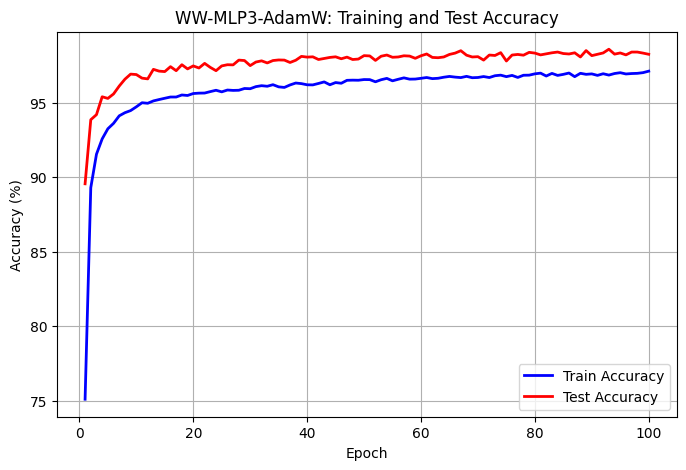

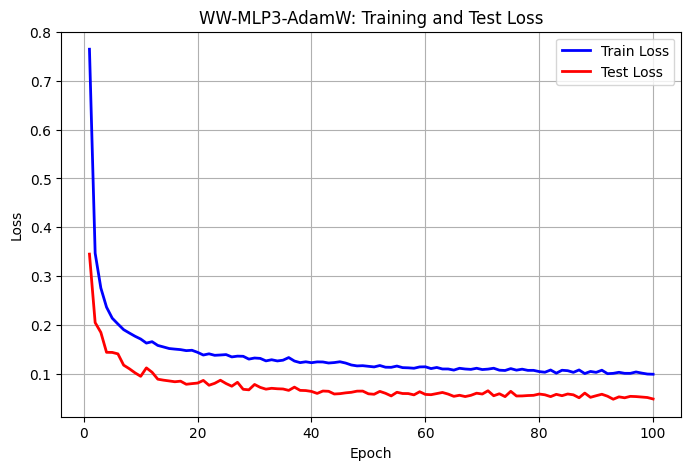

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training results from CSV
data = pd.read_csv(f"{experiment}_results.csv")

# Extract values
epochs = range(1, len(data) + 1)  # Epoch numbers
train_loss = data["train_loss"]
test_loss = data["test_loss"]
train_acc = data["train_acc"]
test_acc = data["test_acc"]

# Create figure for accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, '-b', label="Train Accuracy", linewidth=2)
plt.plot(epochs, test_acc, '-r', label="Test Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title(f"{experiment}: Training and Test Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_plot.png")  # Save plot
plt.show()

# Create figure for loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, '-b', label="Train Loss", linewidth=2)
plt.plot(epochs, test_loss, '-r', label="Test Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{experiment}: Training and Test Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")  # Save plot
plt.show()

In [22]:
## Plot Layer Alphas per Epoch


Available layers in CSV (longname): ['fc1' 'fc2' 'fc3']
Filtered layers: ['fc1' 'fc2' 'fc3']


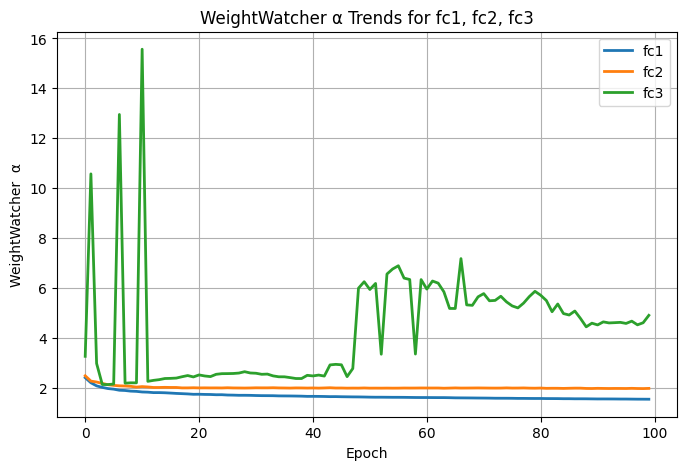

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load WeightWatcher results from CSV
data = pd.read_csv(f"ww_{experiment}_results.csv")

# Ensure correct data structure
required_columns = {"epoch", "longname", "alpha"}
if not required_columns.issubset(data.columns):
    raise ValueError(f"CSV file must contain {required_columns} columns.")

# Convert alpha to numeric and drop invalid values
data["alpha"] = pd.to_numeric(data["alpha"], errors="coerce")
data = data.dropna(subset=["alpha"])

# Print available layer names for debugging
print("Available layers in CSV (longname):", data["longname"].unique())

# Filter for fc1, fc2, fc3 using longname
filtered_data = data[data["longname"].str.contains(r"fc[123]", case=False, na=False)]

# Print filtered layer names for debugging
print("Filtered layers:", filtered_data["longname"].unique())

# Aggregate duplicate layer entries per epoch (compute mean α if needed)
filtered_data = filtered_data.groupby(["epoch", "longname"], as_index=False)["alpha"].mean()

# Pivot table to get layers as columns, epochs as rows
pivot_data = filtered_data.pivot(index="epoch", columns="longname", values="alpha")

# Plot only fc1, fc2, fc3 α trends (if they exist)
plt.figure(figsize=(8, 5))
plotted_layers = []  # Track layers actually plotted

for layer in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[layer], label=layer, linewidth=2)
    plotted_layers.append(layer)  # Track plotted layers

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("WeightWatcher  α")
plt.title("WeightWatcher α Trends for fc1, fc2, fc3")
plt.grid(True)

# Only add legend if at least one layer was plotted
if plotted_layers:
    plt.legend()

# Save and show plot
plt.savefig(f"ww_{experiment}_alpha_fc_layers.png")
plt.show()

## Rerun the same experiment, but with WeightWatcher results adjusted for Dropout

In [36]:
import copy
import torch
import numpy as np

def create_dropout_weighted_copy(model):
    """
    THIS IS EXPERIMENTAL
    
    Creates a deep copy of the given MLP model where the weights of each layer
    are randomly zeroed out according to the layer's dropout rate.

    Parameters:
        model (torch.nn.Module): The original MLP model.

    Returns:
        torch.nn.Module: A deep copy of the model with modified weights.
    """
    # Create a deep copy of the model
    model_copy = copy.deepcopy(model)

    # Define a mapping from layer names to dropout rates
    dropout_rates = {
        "fc1": model.dropout1.p if hasattr(model, "dropout1") else 0,
        "fc2": model.dropout2.p if hasattr(model, "dropout2") else 0,
        "fc3": 0  # No dropout in the output layer
    }

    # Iterate through the model layers and zero out weights according to dropout rate
    for name, layer in model_copy.named_modules():
        if isinstance(layer, torch.nn.Linear) and name in dropout_rates:
            dropout_rate = dropout_rates[name]
            if dropout_rate > 0:
                # Convert weight tensor to NumPy for easy manipulation
                weight_np = layer.weight.detach().cpu().numpy()

                # Compute number of elements to drop
                num_elements = weight_np.size
                num_drop = int(num_elements * dropout_rate)

                # Create dropout mask
                dropout_mask = np.ones(num_elements, dtype=np.float32)
                dropout_indices = np.random.choice(num_elements, num_drop, replace=False)
                dropout_mask[dropout_indices] = 0

                # Apply dropout mask
                weight_np *= dropout_mask.reshape(weight_np.shape)

                # Convert back to PyTorch tensor and assign to model copy
                layer.weight.data = torch.tensor(weight_np, dtype=layer.weight.dtype, device=layer.weight.device)

    return model_copy

In [39]:

# ================ Data Augmentation and MNIST Datasets ================
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ================ Model, Loss, Optimizer, Scheduler ================

num_epochs = 100

model = MLP3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(train_loader))


experiment = "WW-MLP3-AdamW-wDP"


In [44]:

# Initialize storage for accuracy/loss tracking
train_losses, test_losses = [], []
train_acc_dpon, train_acc_dpoff = [], []
test_accuracies = []

# Initialize dataframe to store WeightWatcher results
ww_results_original = pd.DataFrame()
ww_results_dropout = pd.DataFrame()


# Training loop
num_epochs = 10
best_test_acc = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc_on = correct / total * 100
    train_losses.append(train_loss)
    train_acc_dpon.append(train_acc_on)

    train_loss_off, train_acc_off = evaluate(model, train_loader, criterion, device)
    train_acc_dpoff.append(train_acc_off)

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    scheduler.step()

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        os.makedirs("checkpoints", exist_ok=True)
        torch.save(model.state_dict(), f"checkpoints/mlp3_best.pth")

    # Run WeightWatcher for original model
    ww_results_original = run_weightwatcher(model, epoch, ww_results_original, "original")

    # Create dropout-weighted copy and run WeightWatcher on it
    dropout_weighted_model = create_dropout_weighted_copy(model)
    ww_results_dropout = run_weightwatcher(dropout_weighted_model, epoch, ww_results_dropout, "dropout")

    log_msg = (f"Epoch {epoch+1}/{num_epochs} - "
               f"Train Loss: {train_loss:.4f}, Train Acc (Dropout ON): {train_acc_on:.2f}% - "
               f"Train Acc (Dropout OFF): {train_acc_off:.2f}% - "
               f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    print(log_msg)
    logging.info(log_msg)
    torch.mps.synchronize()

# Save WeightWatcher results
ww_results_original.to_csv(f"ww_{experiment}_results_original.csv", index=False)
ww_results_dropout.to_csv(f"ww_{experiment}_results_dropout.csv", index=False)

# Save accuracy/loss results
pd.DataFrame({
    "train_loss": train_losses, 
    "test_loss": test_losses, 
    "train_acc_dpon": train_acc_dpon,  
    "train_acc_dpoff": train_acc_dpoff,  
    "test_acc": test_accuracies
}).to_csv(f"{experiment}_results.csv", index=False)

2025-03-19 16:28:09,409 - INFO - Epoch 1/10 - Train Loss: 0.1680, Train Acc (Dropout ON): 94.77% - Train Acc (Dropout OFF): 96.88% - Test Loss: 0.0937, Test Acc: 97.06%


Epoch 1/10 - Train Loss: 0.1680, Train Acc (Dropout ON): 94.77% - Train Acc (Dropout OFF): 96.88% - Test Loss: 0.0937, Test Acc: 97.06%


2025-03-19 16:28:22,747 - INFO - Epoch 2/10 - Train Loss: 0.1624, Train Acc (Dropout ON): 94.94% - Train Acc (Dropout OFF): 96.92% - Test Loss: 0.0890, Test Acc: 97.24%


Epoch 2/10 - Train Loss: 0.1624, Train Acc (Dropout ON): 94.94% - Train Acc (Dropout OFF): 96.92% - Test Loss: 0.0890, Test Acc: 97.24%


2025-03-19 16:28:35,986 - INFO - Epoch 3/10 - Train Loss: 0.1576, Train Acc (Dropout ON): 95.15% - Train Acc (Dropout OFF): 97.00% - Test Loss: 0.0926, Test Acc: 97.11%


Epoch 3/10 - Train Loss: 0.1576, Train Acc (Dropout ON): 95.15% - Train Acc (Dropout OFF): 97.00% - Test Loss: 0.0926, Test Acc: 97.11%


2025-03-19 16:28:49,174 - INFO - Epoch 4/10 - Train Loss: 0.1586, Train Acc (Dropout ON): 95.11% - Train Acc (Dropout OFF): 97.09% - Test Loss: 0.0906, Test Acc: 97.09%


Epoch 4/10 - Train Loss: 0.1586, Train Acc (Dropout ON): 95.11% - Train Acc (Dropout OFF): 97.09% - Test Loss: 0.0906, Test Acc: 97.09%


2025-03-19 16:29:02,383 - INFO - Epoch 5/10 - Train Loss: 0.1515, Train Acc (Dropout ON): 95.31% - Train Acc (Dropout OFF): 97.15% - Test Loss: 0.0894, Test Acc: 97.26%


Epoch 5/10 - Train Loss: 0.1515, Train Acc (Dropout ON): 95.31% - Train Acc (Dropout OFF): 97.15% - Test Loss: 0.0894, Test Acc: 97.26%


2025-03-19 16:29:15,849 - INFO - Epoch 6/10 - Train Loss: 0.1512, Train Acc (Dropout ON): 95.27% - Train Acc (Dropout OFF): 97.30% - Test Loss: 0.0860, Test Acc: 97.46%


Epoch 6/10 - Train Loss: 0.1512, Train Acc (Dropout ON): 95.27% - Train Acc (Dropout OFF): 97.30% - Test Loss: 0.0860, Test Acc: 97.46%


2025-03-19 16:29:29,165 - INFO - Epoch 7/10 - Train Loss: 0.1498, Train Acc (Dropout ON): 95.39% - Train Acc (Dropout OFF): 97.25% - Test Loss: 0.0844, Test Acc: 97.24%


Epoch 7/10 - Train Loss: 0.1498, Train Acc (Dropout ON): 95.39% - Train Acc (Dropout OFF): 97.25% - Test Loss: 0.0844, Test Acc: 97.24%


2025-03-19 16:29:43,254 - INFO - Epoch 8/10 - Train Loss: 0.1484, Train Acc (Dropout ON): 95.58% - Train Acc (Dropout OFF): 97.47% - Test Loss: 0.0838, Test Acc: 97.19%


Epoch 8/10 - Train Loss: 0.1484, Train Acc (Dropout ON): 95.58% - Train Acc (Dropout OFF): 97.47% - Test Loss: 0.0838, Test Acc: 97.19%


2025-03-19 16:29:57,029 - INFO - Epoch 9/10 - Train Loss: 0.1479, Train Acc (Dropout ON): 95.48% - Train Acc (Dropout OFF): 97.41% - Test Loss: 0.0820, Test Acc: 97.36%


Epoch 9/10 - Train Loss: 0.1479, Train Acc (Dropout ON): 95.48% - Train Acc (Dropout OFF): 97.41% - Test Loss: 0.0820, Test Acc: 97.36%


2025-03-19 16:30:11,362 - INFO - Epoch 10/10 - Train Loss: 0.1437, Train Acc (Dropout ON): 95.50% - Train Acc (Dropout OFF): 97.44% - Test Loss: 0.0740, Test Acc: 97.74%


Epoch 10/10 - Train Loss: 0.1437, Train Acc (Dropout ON): 95.50% - Train Acc (Dropout OFF): 97.44% - Test Loss: 0.0740, Test Acc: 97.74%


In [49]:
data = pd.read_csv(f"{experiment}_results.csv")
data

,train_loss,test_loss,train_acc_dpon,train_acc_dpoff,test_acc
0,0.167985,0.093692,94.768333,96.880000,97.06
1,0.162406,0.089019,94.938333,96.918333,97.24
2,0.157586,0.092591,95.153333,97.000000,97.11
3,0.158631,0.090624,95.111667,97.091667,97.09
4,0.151534,0.089406,95.313333,97.150000,97.26
5,0.151220,0.086029,95.270000,97.305000,97.46
6,0.149802,0.084391,95.390000,97.250000,97.24
7,0.148366,0.083762,95.585000,97.473333,97.19
8,0.147911,0.081998,95.480000,97.405000,97.36
9,0.143652,0.073959,95.498333,97.441667,97.74


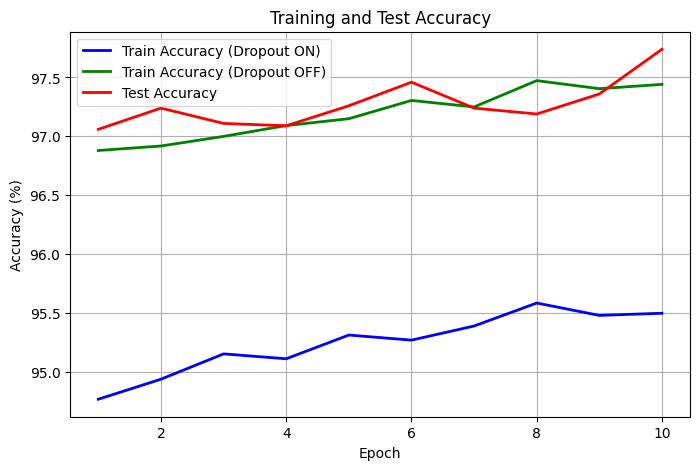

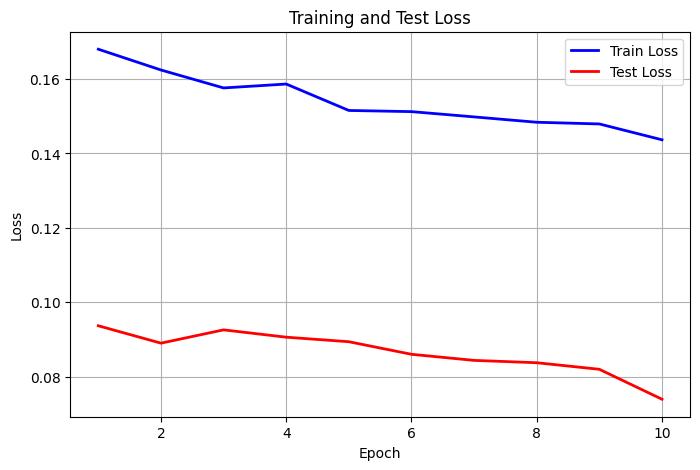

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training results from CSV
data = pd.read_csv(f"{experiment}_results.csv")

# Extract values
epochs = range(1, len(data) + 1)  # Epoch numbers
train_loss = data["train_loss"]
test_loss = data["test_loss"]
train_acc_dpon = data["train_acc_dpon"]  # Train accuracy with Dropout ON
train_acc_dpoff = data["train_acc_dpoff"]  # Train accuracy with Dropout OFF
test_acc = data["test_acc"]  # Test accuracy

# Create figure for accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc_dpon, '-b', label="Train Accuracy (Dropout ON)", linewidth=2)
plt.plot(epochs, train_acc_dpoff, '-g', label="Train Accuracy (Dropout OFF)", linewidth=2)
plt.plot(epochs, test_acc, '-r', label="Test Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_plot.png")  # Save plot
plt.show()

# Create figure for loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, '-b', label="Train Loss", linewidth=2)
plt.plot(epochs, test_loss, '-r', label="Test Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")  # Save plot
plt.show()

Available layers in CSV (longname): ['fc1' 'fc2' 'fc3']
Filtered layers: ['fc1' 'fc2' 'fc3']


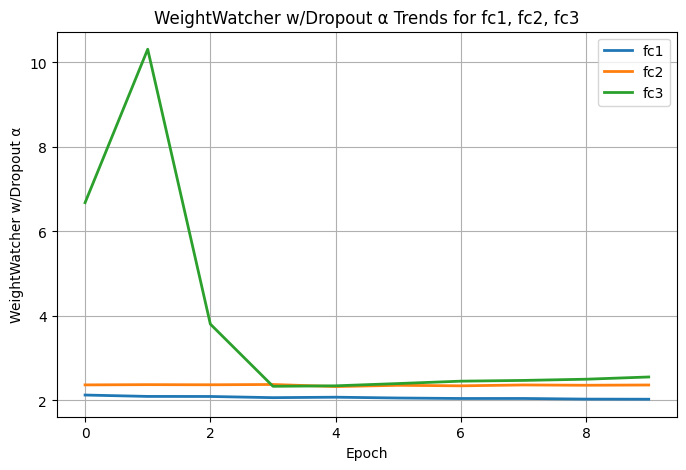

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Load WeightWatcher results from CSV
data = pd.read_csv(f"ww_{experiment}_results_dropout.csv")

# Ensure correct data structure
required_columns = {"epoch", "longname", "alpha"}
if not required_columns.issubset(data.columns):
    raise ValueError(f"CSV file must contain {required_columns} columns.")

# Convert alpha to numeric and drop invalid values
data["alpha"] = pd.to_numeric(data["alpha"], errors="coerce")
data = data.dropna(subset=["alpha"])

# Print available layer names for debugging
print("Available layers in CSV (longname):", data["longname"].unique())

# Filter for fc1, fc2, fc3 using longname
filtered_data = data[data["longname"].str.contains(r"fc[123]", case=False, na=False)]

# Print filtered layer names for debugging
print("Filtered layers:", filtered_data["longname"].unique())

# Aggregate duplicate layer entries per epoch (compute mean α if needed)
filtered_data = filtered_data.groupby(["epoch", "longname"], as_index=False)["alpha"].mean()

# Pivot table to get layers as columns, epochs as rows
pivot_data = filtered_data.pivot(index="epoch", columns="longname", values="alpha")

# Plot only fc1, fc2, fc3 α trends (if they exist)
plt.figure(figsize=(8, 5))
plotted_layers = []  # Track layers actually plotted

for layer in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[layer], label=layer, linewidth=2)
    plotted_layers.append(layer)  # Track plotted layers

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("WeightWatcher w/Dropout α")
plt.title("WeightWatcher w/Dropout α Trends for fc1, fc2, fc3")
plt.grid(True)

# Only add legend if at least one layer was plotted
if plotted_layers:
    plt.legend()

# Save and show plot
plt.savefig("alpha_fc_layers.png")
plt.show()